# DIM0782 - Machine Learning (DIMAp/UFRN/2024.1)

## Preprocessing the data

### Transforming non-structured data to structured data

This is textual data, so the first step is to turn it into structured data by applying a transformer. I'm going to work mostly with BERT here.

First, I'm going to define the imports block.

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb

Now reading the sentiments dataset:

In [2]:
sentiments_df = pd.read_csv("datasets/twitter_sentiment_base_original.csv", usecols=["text", "label"])
sentiments_df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


###  Creating a Shorter Dataset (Optional Step)
-- -------------------------

This might be helpful in case your base is originally too big to be processed on a reasonable time for this exercise. Running this block would still allow you to run the subsequent blocks of code with no issues. You can totally skip this step as well in case you have the computing power to process the original dataset.

In [3]:
sample_size, random_state = 4000, 42
sampled_data = []

for i in range(6): ## Since we have 6 sentimens, labeled from 0 to 5
    sampled_data.append(sentiments_df[sentiments_df['label'] == i].sample(n=sample_size, random_state=random_state))

sentiments_df = pd.concat(sampled_data)
sentiments_df

,text,label
133243,ive learned to surround myself with women who ...,0
88501,i already feel crappy because of this and you ...,0
131379,i feel like i have lost mourned and moved past...,0
148369,i could write a whole lot more about why im fe...,0
134438,i always seem to feel inadequate,0
...,...,...
44216,i feel a strange sadness because the downhill ...,5
370216,i feel absolutely amazing when i have a conver...,5
118400,im not going to repeat every word written in t...,5
347704,i feel impressed to extend this to all,5


-- ----------
### End of Optional Block

Now I'm going to utilize a BERT tokenizer to transform the text data that I have.

In [4]:
## Loading the pretrained model and tokenizer
tokenizer = (ppb.DistilBertTokenizer).from_pretrained('distilbert-base-uncased')
model = (ppb.DistilBertModel).from_pretrained('distilbert-base-uncased')

## Tokenizing w/ BERT
sentiments_tokenized = sentiments_df["text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

The code above outputs the tokenized data with rows of different sizes, since each sentence has a different length. We now need to apply a process called padding in order to make all of the sentences with equal size. We will also need an attention mask, which will tell BERT which rows he should consider the data or not.

In [5]:
## Generating a new dataframe with the tokenized data appended with their associated labels
biggest_sentence_length = 0
for i in sentiments_tokenized.values:
    if len(i) > biggest_sentence_length:
        biggest_sentence_length = len(i)

## Getting the values padded and the attention mask
sentiments_tokenized_padded = np.array([i + [0]*(biggest_sentence_length-len(i)) for i in sentiments_tokenized.values])
attention_mask = np.where(sentiments_tokenized_padded != 0, 1, 0)

Now we're finally going to process those input IDs that we generated on the steps above and we will generate the actual BERT embeddings. Given the size of the dataset, I ran multiple tests and realized that memory would be an issue. I need to split this into batches and work from there.

In [ ]:
input_ids = torch.tensor(sentiments_tokenized_padded)
attention_mask = torch.tensor(attention_mask)
batch_size = 4000      # Change it as it is necessary 
all_hidden_states = [] # BERT generates what we call hidden states

def batch_generator(input_ids, attention_mask, batch_size):
    for i in range(0, len(input_ids), batch_size):
        yield input_ids[i:i+batch_size], attention_mask[i:i+batch_size]

## Processes the input over batches through the help of a generator
with torch.no_grad():
    for batch_ids, batch_mask in batch_generator(input_ids, attention_mask, batch_size):
        outputs = model(batch_ids, attention_mask=batch_mask)
        all_hidden_states.append(outputs.last_hidden_state)

## Concatenates all batch results
last_hidden_states = torch.cat(all_hidden_states, dim=0)

#### Optional (minor)
-- --------------

Getting all of that on a file to ensure this data gets saved. Can be adapted to retrieve a previously saved tensor as well, so that you don't have to run the embeddings algorithm on the future.

In [5]:
## Saves or loads tensor to or from a file
# torch.save(last_hidden_states, 'tensor.pt')
last_hidden_states = torch.load('datasets/tensor.pt')

-- ------------
#### End of Minor Optional Block

Now we can extract the features:

In [6]:
sentiments_features = last_hidden_states[:,0,:].numpy()
labels = sentiments_df['label']

I'm also going to develop this auxiliary block that will be able to save my dataset with the n-dimension features I generate as a result from applying the techniques.

In [29]:
def features_to_csv(features, labels, filename):
    df = pd.DataFrame(features, columns=[f'feature_{i}' for i in range(features.shape[1])])
    df['label'] = labels.to_numpy()
    
    df.to_csv(filename, index=False)    

## This is the line that will change depending on the file I want to generate
features_to_csv(sentiments_features, labels, 'datasets/twitter_sentiment_base_ready.csv')

## Reduction of Instances

As part of this work, it is required to reduce instances on my dataset.

The first dataset I was working with had about 400000 records, and I could not process the embeddings and tokenization on a timely manner. I had to do a brusk reduction on the size, so now I don't have a dataset that is that big. My goal here is just to get some sampling of 80% of the already reduced dataset.

In [31]:
## Variables for the sampling conditions
sample_size, random_state = 3200, 42
sampled_data = []
sentiments_processed_df = pd.read_csv('datasets/twitter_sentiment_base_ready.csv')

for i in range(6): ## Since we have 6 sentimens, labeled from 0 to 5
    sampled_data.append(sentiments_processed_df[sentiments_processed_df['label'] == i].sample(n=sample_size, random_state=random_state))

sampled_sentiments_df = pd.concat(sampled_data)
sampled_sentiments_df.to_csv('datasets/twitter_sentiments_base_sampled.csv', index=False)

## Attribute selection (w/ Decision Trees)

Decision trees are quite useful for the purpose of doing attribute (or feature) selection because they inherently perform feature selection by splitting nodes based on the most informative features. By using a decision tree, we can identify which attributes (or features) contribute most to predicting the output, making it a practical approach for reducing dimensionality and improving model interpretability.

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

sentiments_embeddings_train, sentiments_embeddings_test, sentiments_labels_train, sentiments_labels_test = train_test_split(sentiments_features, labels, test_size=0.2, random_state=42)

# Initialize the classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model
decision_tree.fit(sentiments_embeddings_train, sentiments_labels_train)

# Get feature importances
importances = decision_tree.feature_importances_

# Now we sort the importances on descending order and select the top X features - (X: originally 50)
indices = np.argsort(importances)[::-1]
top_features = indices[:50]

# Finally, we select only the top features that were applied
sentiments_embeddings_train_reduced = sentiments_embeddings_train[:, top_features]
sentiments_embeddings_test_reduced = sentiments_embeddings_test[:, top_features]

I'm adding this auxiliary block here for merging the results back to a single sentiments embeddings array.

In [18]:
sentiments_embeddings_decision_tree = np.concatenate((sentiments_embeddings_train_reduced, sentiments_embeddings_test_reduced))
sentiments_embeddings_decision_tree.shape

(24000, 50)

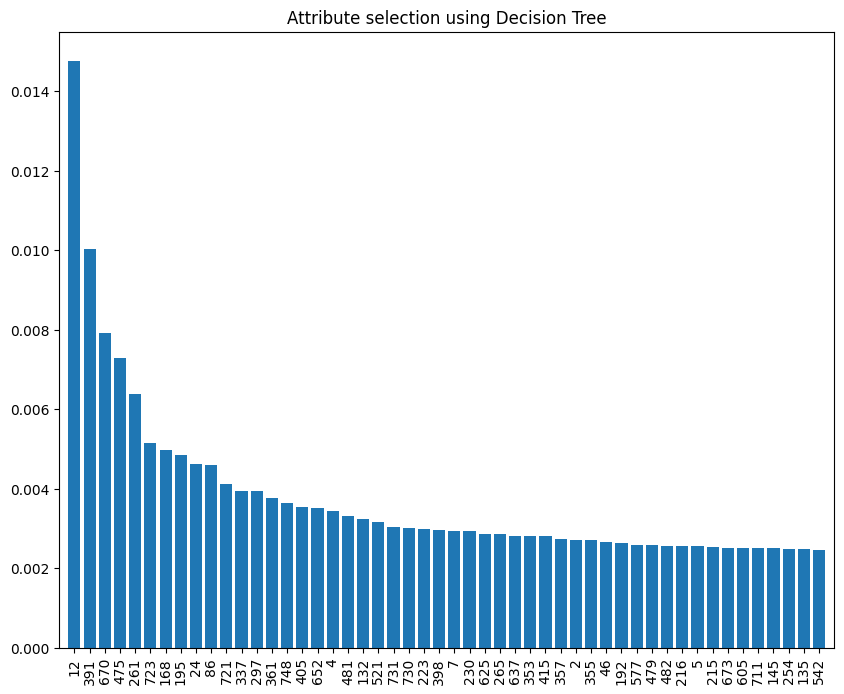

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title("Attribute selection using Decision Tree")
plt.bar(range(sentiments_embeddings_train_reduced.shape[1]), importances[top_features], align='center')
plt.xticks(range(sentiments_embeddings_train_reduced.shape[1]), top_features, rotation=90)
plt.xlim([-1, sentiments_embeddings_train_reduced.shape[1]])

plt.show()

## Principal Component Analysis (PCA)

Running Principal Component Analysis (PCA) is a powerful method to reduce the dimensionality of our data while retaining as much variability as possible. 

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
sentiments_features_scaled = scaler.fit_transform(sentiments_features)

# Choose the number of components (example: reduce dimensions to keep 95% of the variance)
pca = PCA(n_components=0.95)
sentiments_pca = pca.fit_transform(sentiments_features_scaled)

print(f"Number of components kept: {pca.n_components_}")

Number of components kept: 214


Now, let's examine the explained variance of the PCA. This will tell us how much information (variability) was retained.

In [23]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total variance explained: {sum(explained_variance)}")

Explained variance by each component: [0.13098411 0.09063568 0.05532153 0.05026966 0.03718181 0.0335627
 0.0309852  0.02734337 0.0227272  0.02120668 0.01880902 0.01750765
 0.01609287 0.01548563 0.01466154 0.01341947 0.01170103 0.0106961
 0.00984342 0.00928938 0.00894261 0.00857401 0.00804609 0.00794713
 0.00754434 0.00692301 0.00656436 0.00629978 0.00601705 0.00585967
 0.00556609 0.0052062  0.00501069 0.00494067 0.00479707 0.0044747
 0.00426741 0.00422726 0.00414841 0.00405941 0.00389931 0.00388706
 0.00369942 0.00356525 0.00352549 0.0033838  0.00334331 0.00321038
 0.00312165 0.00301219 0.00290797 0.00276007 0.00272287 0.00267909
 0.00256318 0.00250167 0.00243577 0.00240358 0.00231875 0.00229849
 0.00227383 0.00217715 0.00214474 0.00213408 0.00209029 0.0020382
 0.00202275 0.00193709 0.00189465 0.00186346 0.0018465  0.00180737
 0.00179504 0.00171924 0.00168555 0.00164337 0.00163096 0.00159486
 0.00155878 0.00151573 0.00150573 0.0014916  0.00145182 0.00144282
 0.00142747 0.00140939 0.001

Let us now finally visualize the transformed data.

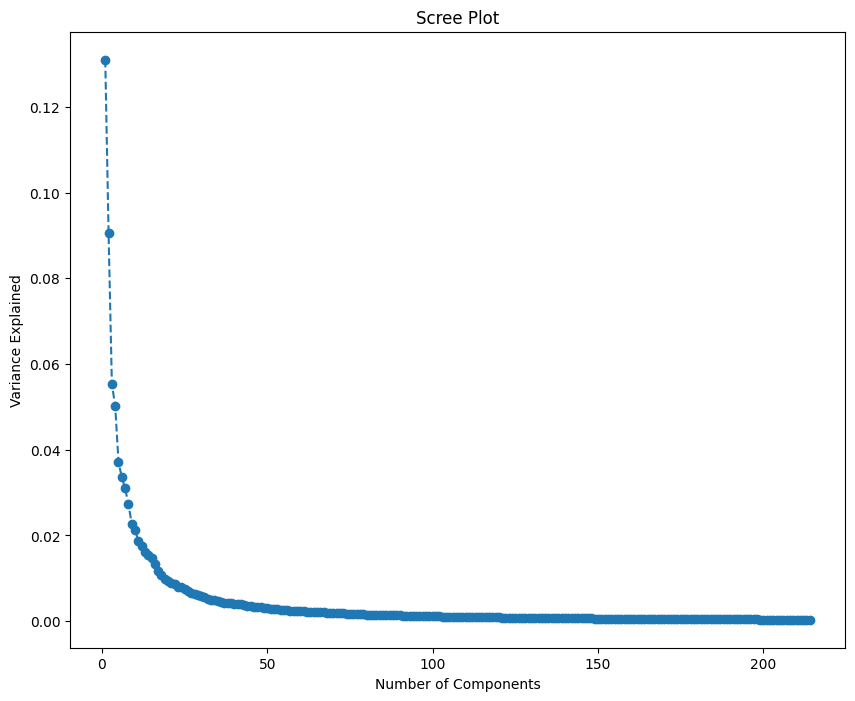

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(range(1, 215), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

The scree plot generated is a graphical representation of the variance explained by each principal component the analysis.

The x-axis represents the number of principal components. In the plot, it ranges from 1 to over 200.
The y-axis represents the variance explained by each principal component. It shows the proportion of the dataset’s total variance.
Elbow Method: Typically, the goal of a scree plot is to identify the 'elbow' of the graph, which indicates the point at which the variance explained by each additional component drops off and becomes minimal. This point is considered a good cut-off for reducing the number of components because beyond this point, you're getting diminishing returns on explained variance.

In our plot, there is a steep drop after the first few components, then the decline slows significantly. This suggests that the first few components capture a substantial amount of the information (variance) in the dataset. After this initial steep drop, the plot levels off around the 40-component mark, indicating that each additional component contributes less and less.

It’s worth noting that the first component explains significantly more variance than the subsequent ones. In practical terms, this could mean that there is one dominant feature or pattern in your data that accounts for most of the variance, with each additional feature contributing less to explaining the dataset.

Based on this plot, we might consider retaining only the components before the curve starts to flatten if you aim to reduce dimensionality while retaining most of the information.

That's why I'm going to run the PCA algorithm again, but changing the n parameter.

In [25]:
pca_round_two = PCA(n_components=0.70)
sentiments_pca = pca_round_two.fit_transform(sentiments_features_scaled)

print(f"Number of components kept: {pca_round_two.n_components_}")

Number of components kept: 29


Now let's generate this scree plot again:

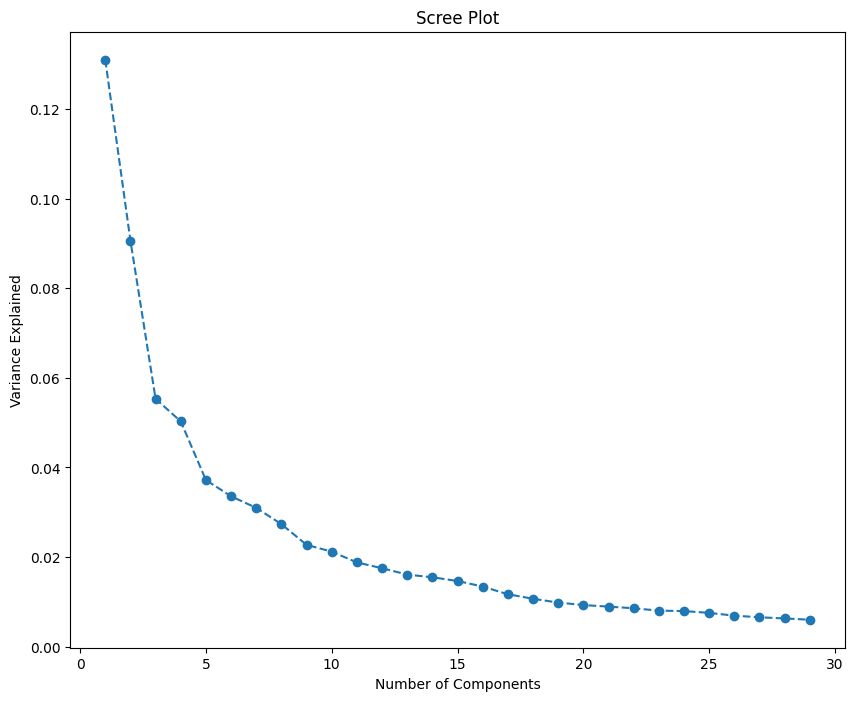

In [26]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 30), pca_round_two.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.show()

## Multinomial Logistic Regression

Given that the dataset has 6 possible sentiments (labels), it won't be possible to run Logistic Regression (because the data decision is not binary). Because of that, we can investigate the behavior of applying a multinomial logistic regression classification algorithm.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Invoking the logistic regression model
logistic_regression_sentiments = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1500)

Now, let's actually run the multinomial logistic regression.

In [13]:
# Runs the model with the percentage split dataset method - uncomment if needed
# logistic_regression_sentiments.fit(train_features, train_labels)

# Runs the model with the 10-fold cross-validation dataset method - uncomment if needed
scores = cross_val_score(logistic_regression_sentiments, sentiments_features, labels, cv=10)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now let's see the score (accuracy) of the algorithm:

In [14]:
#print("Accuracy using the percentage split dataset:", logistic_regression_sentiments.score(test_features, test_labels))
print("Average Accuracy (10-fold)", scores.mean())
print("Standard Deviation of Accuracy:", scores.std())

Average Accuracy (10-fold) 0.6074583333333334
Standard Deviation of Accuracy: 0.011299966199556134


## k-Nearest Neighbors (kNN)

Let us implement the k-Nearest Neighbors algorithm and understand how it behaves with our sentiments dataset.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Create the KNN model with a specified number of neighbors; e.g., k=5
knn = KNeighborsClassifier(n_neighbors=5)

Now let's actually run the kNN Algorithm, with the parameters adjusted as above. This version comprehends the percentage test split, but I'll also show it using the 10-fold cross validation method.

In [49]:
# Training the model
knn.fit(train_features, train_labels)

# Predicting the test set
labels_predict = knn.predict(test_features)

print("Accuracy of kNN (5 neighbors, 70/30 split):", accuracy_score(test_labels, labels_predict))

Accuracy of kNN (5 neighbors, 70/30 split): 0.3075


kNN via the 10-fold cross-validation method:

In [53]:
from sklearn.model_selection import KFold

# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Prepare to collect accuracy scores
accuracies = []

knn_labels = np.array(labels)

# Perform 10-fold CV
for train_index, test_index in kf.split(sentiments_features):
    sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
    labels_train, labels_test = knn_labels[train_index], knn_labels[test_index]

    # Train the kNN Model inside the current fold
    knn.fit(sentiments_train, labels_train)

    # Predict and evaluate the model
    labels_predict = knn.predict(sentiments_test)
    accuracy = accuracy_score(labels_test, labels_predict)
    accuracies.append(accuracy)
    print("Accuracy from this fold:", accuracy)

# Calculate and print the average accuracy and standard deviation
print("Average accuracy:", np.mean(accuracies))
print("Standard deviation of accuracy:", np.std(accuracies))

Accuracy from this fold: 0.3070833333333333
Accuracy from this fold: 0.3129166666666667
Accuracy from this fold: 0.30375
Accuracy from this fold: 0.30916666666666665
Accuracy from this fold: 0.32666666666666666
Accuracy from this fold: 0.3045833333333333
Accuracy from this fold: 0.3016666666666667
Accuracy from this fold: 0.31833333333333336
Accuracy from this fold: 0.30583333333333335
Accuracy from this fold: 0.3075
Average accuracy: 0.30975
Standard deviation of accuracy: 0.007250957791139655


## Decision Tree Classifier

Implementing the Decision Tree Classifier and varying its max depth to compare accuracy. This is using the percentage split method of collecting the data from the dataset.

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Create the Decision Tree Classifier (DTC) model with a specified max depth; e.g., md =5
dtc = DecisionTreeClassifier(max_depth=7, random_state=42)

# Training the model
dtc.fit(train_features, train_labels)

# Predicting the test set
labels_predict = dtc.predict(test_features)

print("Accuracy of Decision Tree Classifier (5 Max-Depth, 70/30 split):", accuracy_score(test_labels, labels_predict))

Accuracy of Decision Tree Classifier (5 Max-Depth, 70/30 split): 0.26916666666666667


Now implementing it via the 10-fold cross-validation method:

In [51]:
from sklearn.model_selection import KFold

# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the Decision Tree Classifier (DTC) model with a specified max depth; e.g., md =5
dtc = DecisionTreeClassifier(max_depth=7, random_state=42)

# Prepare to collect accuracy scores
accuracies = []

dtc_labels = np.array(labels)

# Perform 10-fold CV
for train_index, test_index in kf.split(sentiments_features):
    sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
    labels_train, labels_test = dtc_labels[train_index], dtc_labels[test_index]

    # Train the DTC Model inside the current fold
    dtc.fit(sentiments_train, labels_train)

    # Predict and evaluate the model
    labels_predict = dtc.predict(sentiments_test)
    accuracy = accuracy_score(labels_test, labels_predict)
    accuracies.append(accuracy)
    print("Accuracy from this fold:", accuracy)

# Calculate and print the average accuracy and standard deviation
print("Average accuracy:", np.mean(accuracies))
print("Standard deviation of accuracy:", np.std(accuracies))

Accuracy from this fold: 0.26916666666666667
Accuracy from this fold: 0.27125
Accuracy from this fold: 0.27666666666666667
Accuracy from this fold: 0.2725
Accuracy from this fold: 0.2633333333333333
Accuracy from this fold: 0.2529166666666667
Accuracy from this fold: 0.2866666666666667
Accuracy from this fold: 0.26916666666666667
Accuracy from this fold: 0.27208333333333334
Accuracy from this fold: 0.2608333333333333
Average accuracy: 0.26945833333333336
Standard deviation of accuracy: 0.008678377504528783


## Gaussian Naive Bayes

Implementing the Gaussian Naive Bayes classifier. Parameters are priors = 0 (array of prior probabilities) and var_smoothing: 1e-9, as per the professor's specification.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Create the Gaussian Naive Bayes (GNB) model
gnb = GaussianNB(priors=None, var_smoothing=1e-9)

# Training the model
gnb.fit(train_features, train_labels)

# Predicting the test set
labels_predict = gnb.predict(test_features)

print("Accuracy of Gaussian Naive Bayes:", accuracy_score(test_labels, labels_predict))

Accuracy of Gaussian Naive Bayes: 0.4225


Now with the 10-fold cross-validation method:

In [23]:
from sklearn.model_selection import KFold

# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create the Decision Tree Classifier (DTC) model with a specified max depth; e.g., md =5
gnb = GaussianNB(priors=None, var_smoothing=1e-9)

# Prepare to collect accuracy scores
accuracies = []

gnb_labels = np.array(labels)

# Perform 10-fold CV
for train_index, test_index in kf.split(sentiments_features):
    sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
    labels_train, labels_test = gnb_labels[train_index], gnb_labels[test_index]

    # Train the GNB Model inside the current fold
    gnb.fit(sentiments_train, labels_train)

    # Predict and evaluate the model
    labels_predict = gnb.predict(sentiments_test)
    accuracy = accuracy_score(labels_test, labels_predict)
    accuracies.append(accuracy)
    print("Accuracy from this fold:", accuracy)

# Calculate and print the average accuracy and standard deviation
print("Average accuracy:", np.mean(accuracies))
print("Standard deviation of accuracy:", np.std(accuracies))

Accuracy from this fold: 0.4225
Accuracy from this fold: 0.42375
Accuracy from this fold: 0.4033333333333333
Accuracy from this fold: 0.43
Accuracy from this fold: 0.4
Accuracy from this fold: 0.41541666666666666
Accuracy from this fold: 0.4025
Accuracy from this fold: 0.43666666666666665
Accuracy from this fold: 0.4225
Accuracy from this fold: 0.41583333333333333
Average accuracy: 0.41724999999999995
Standard deviation of accuracy: 0.011623730516108452


## Multilayer Perceptron (MLP)

The Multilayer Perceptron (MLP) is a type of artificial neural network that is widely used for solving complex pattern recognition and classification problems. It belongs to a larger class of feedforward neural networks and consists of at least three layers of nodes: an input layer, one or more hidden layers, and an output layer.

### Percentage Split

Starting the classifier for neurons amount: 337
Starting the classifier for neurons amount: 387
Starting the classifier for neurons amount: 437


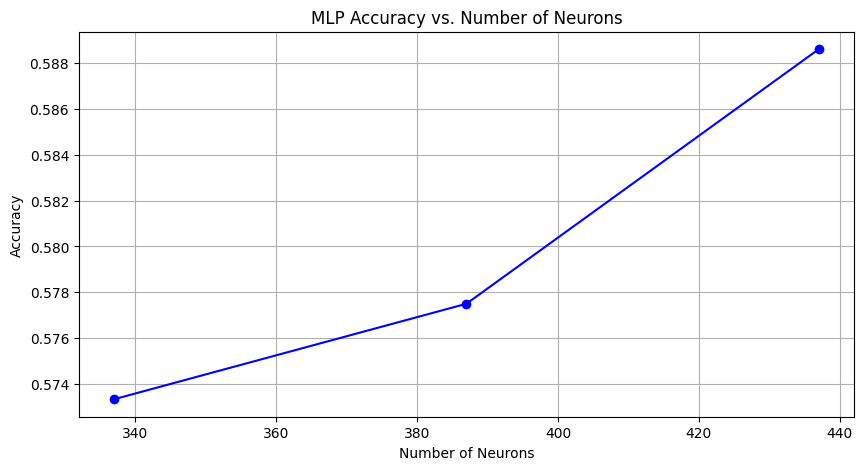

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Calculate the neurons configuration, based on requirements provided by the professor
a_value = 387 # 768 attributes and 6 classes (sentiments)
neurons = [a_value - 50, a_value, a_value + 50]
accuracies = []

# Loop through neuron configurations
for neuron in neurons:
    print("Starting the classifier for neurons amount:", neuron)
    mlp = MLPClassifier(hidden_layer_sizes=(neuron,), max_iter=300, activation='relu', solver='adam', random_state=42)
    mlp.fit(train_features, train_labels)
    labels_predict = mlp.predict(test_features)
    accuracy = accuracy_score(test_labels, labels_predict)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Number of Neurons')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Now we're going to take the number of neurons that we found on the previous experiment, and run the classifier again, but varying the max iterations parameter. 

Starting the classifier for neurons iterations amount: 300
Starting the classifier for neurons iterations amount: 1000
Starting the classifier for neurons iterations amount: 5000


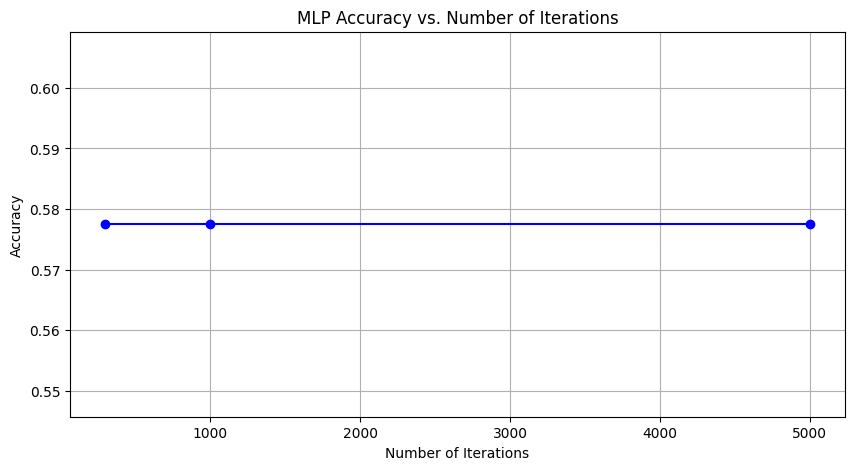

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Initiate the values needed
accuracies = []
iterations = [300, 1000, 5000]
best_neuron_length = 387

# Loop through neuron configurations
for iteration in iterations:
    print("Starting the classifier for neurons iterations amount:", iteration)
    mlp = MLPClassifier(hidden_layer_sizes=(best_neuron_length,), max_iter=iteration, activation='relu', solver='adam', random_state=42)
    mlp.fit(train_features, train_labels)
    labels_predict = mlp.predict(test_features)
    accuracy = accuracy_score(test_labels, labels_predict)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Number of Iterations')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Now, with all of that information, we're going to adjust the learning rate parameter changes, to look for the best configuration available.

Starting the classifier for learning rate amount: 0.001
Starting the classifier for learning rate amount: 0.01
Starting the classifier for learning rate amount: 0.1


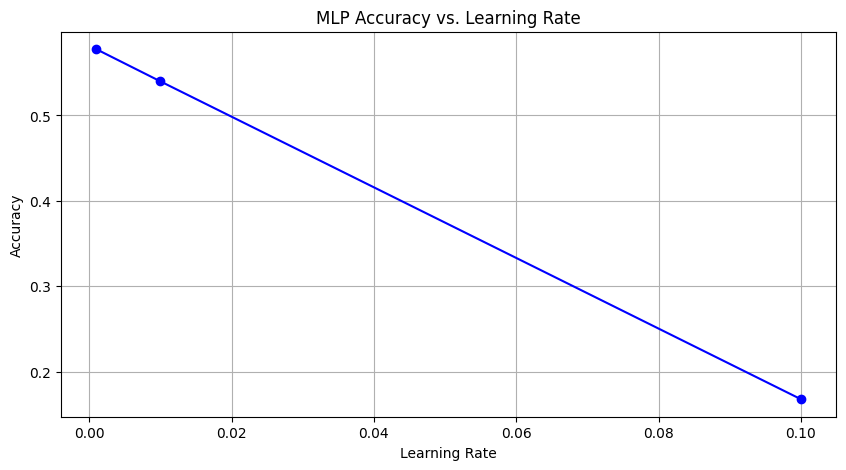

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# Initiate the values needed
accuracies = []
best_max_iter = 300
best_neuron_length = 387
learning_rates = [0.001, 0.01, 0.1]

# Loop through neuron configurations
for learning_rate in learning_rates:
    print("Starting the classifier for learning rate amount:", learning_rate)
    mlp = MLPClassifier(hidden_layer_sizes=(best_neuron_length,), learning_rate_init=learning_rate, max_iter=best_max_iter, activation='relu', solver='adam', random_state=42)
    mlp.fit(train_features, train_labels)
    labels_predict = mlp.predict(test_features)
    accuracy = accuracy_score(test_labels, labels_predict)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 10-fold Cross-Validation

Entering neuron amount of: 337
Processed neurons with 10-fold cross-validation, average accuracy: 0.58675
Entering neuron amount of: 387
Processed neurons with 10-fold cross-validation, average accuracy: 0.5896666666666667
Entering neuron amount of: 437
Processed neurons with 10-fold cross-validation, average accuracy: 0.5850416666666666


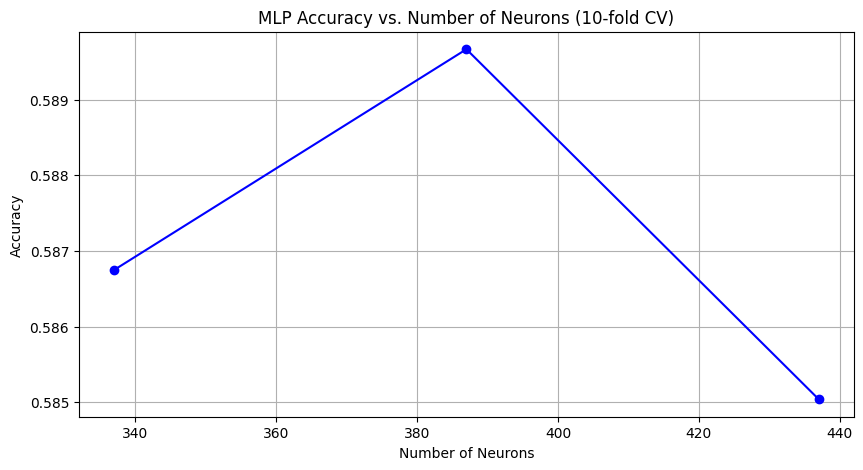

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate the neurons configuration, based on requirements provided by the professor
a_value = 387 # 768 attributes and 6 classes (sentiments)
neurons = [a_value - 50, a_value, a_value + 50]
accuracies = []

# Perform 10-fold CV for each neuron that I'm evaluating
for neuron in neurons:
    print("Entering neuron amount of:", neuron)
    local_accuracy_average = []
    for train_index, test_index in kf.split(sentiments_features):
        sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]
        mlp = MLPClassifier(hidden_layer_sizes=(neuron,), max_iter=300, activation='relu', solver='adam', random_state=42)
        mlp.fit(sentiments_train, labels_train)
        labels_predict = mlp.predict(sentiments_test)
        local_accuracy_average.append(accuracy_score(labels_test, labels_predict))
    print("Processed neurons with 10-fold cross-validation, average accuracy:", np.mean(local_accuracy_average))
    accuracies.append(np.mean(local_accuracy_average))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(neurons, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Number of Neurons (10-fold CV)')
plt.xlabel('Number of Neurons')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Now, with all of that information, we're going to adjust the learning rate parameter changes, to look for the best configuration available.

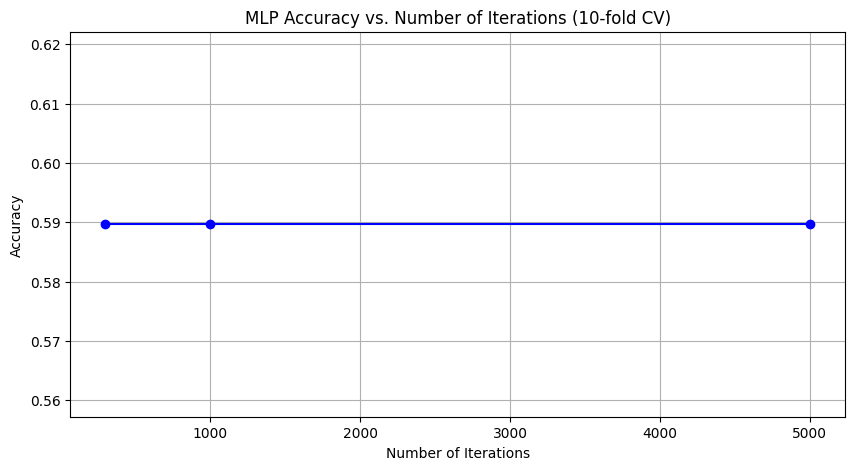

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate the neurons configuration, based on requirements provided by the professor
iterations = [300, 1000, 5000]
best_neuron_length = 387
accuracies = []

# Perform 10-fold CV for each neuron that I'm evaluating
for iteration in iterations:
    print("Entering iteration amount of:", iteration)
    local_accuracy_average = []
    for train_index, test_index in kf.split(sentiments_features):
        sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]
        mlp = MLPClassifier(hidden_layer_sizes=(best_neuron_length,), max_iter=iteration, activation='relu', solver='adam', random_state=42)
        mlp.fit(sentiments_train, labels_train)
        labels_predict = mlp.predict(sentiments_test)
        local_accuracy_average.append(accuracy_score(labels_test, labels_predict))
    print("Processed iteration with 10-fold cross-validation, average accuracy:", np.mean(local_accuracy_average))
    accuracies.append(np.mean(local_accuracy_average))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Number of Iterations (10-fold CV)')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

Final running stage.

Entering learning rate amount of: 0.001
Processed learning rate with 10-fold cross-validation, average accuracy: 0.5896666666666667
Entering learning rate amount of: 0.01
Processed learning rate with 10-fold cross-validation, average accuracy: 0.5697499999999999
Entering learning rate amount of: 0.1
Processed learning rate with 10-fold cross-validation, average accuracy: 0.16666666666666669


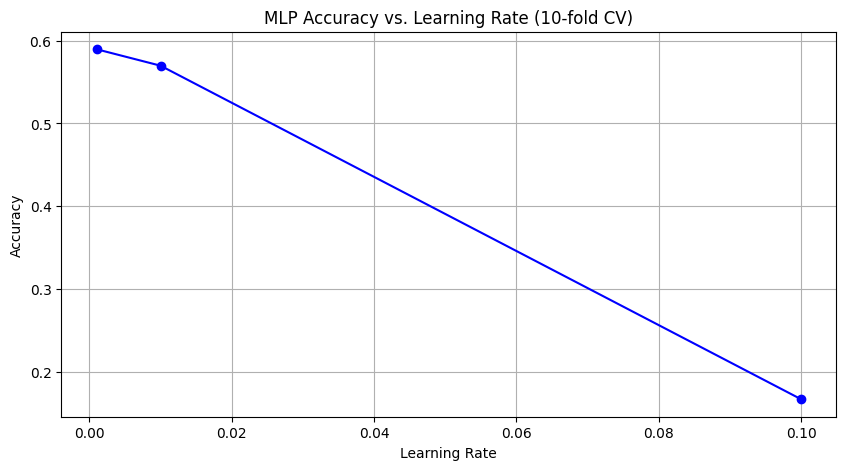

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt


# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Calculate the neurons configuration, based on requirements provided by the professor
best_max_iter = 300
best_neuron_length = 387
learning_rates = [0.001, 0.01, 0.1]
accuracies = []

# Perform 10-fold CV for each neuron that I'm evaluating
for learning_rate in learning_rates:
    print("Entering learning rate amount of:", learning_rate)
    local_accuracy_average = []
    for train_index, test_index in kf.split(sentiments_features):
        sentiments_train, sentiments_test = sentiments_features[train_index], sentiments_features[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]
        mlp = MLPClassifier(hidden_layer_sizes=(best_neuron_length,), max_iter=best_max_iter, learning_rate_init=learning_rate, activation='relu', solver='adam', random_state=42)
        mlp.fit(sentiments_train, labels_train)
        labels_predict = mlp.predict(sentiments_test)
        local_accuracy_average.append(accuracy_score(labels_test, labels_predict))
    print("Processed learning rate with 10-fold cross-validation, average accuracy:", np.mean(local_accuracy_average))
    accuracies.append(np.mean(local_accuracy_average))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, accuracies, marker='o', linestyle='-', color='b')
plt.title('MLP Accuracy vs. Learning Rate (10-fold CV)')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### Searching for parameters using GridSearchCV

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Percentage test split method - can adjust percentage
train_features, test_features, train_labels, test_labels = train_test_split(sentiments_features, labels, test_size=0.3, random_state=42)

# The parameters we will pass to GridSearch
param_grid = {
    'hidden_layer_sizes': np.arange(10, 100),
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'random_state': [42,32,1,2,3,50],
    'max_iter': [300,500,1000,2000]
}

# Create MLPClassifier object
mlp = MLPClassifier(random_state=42)

# Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, verbose=2, n_jobs=-1)

# Fitting GridSearchCV
grid_search.fit(train_features, train_labels)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model found from the grid search
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(test_features)
accuracy = accuracy_score(test_labels, y_pred)

print("Accuracy of the best model: ", accuracy)

## Use this block when you want to import the data from previously saved datasets

In [2]:
working_base = pd.read_csv('datasets/twitter_sentiment_base_ready.csv')
sentiments_features = working_base.loc[:, working_base.columns.str.startswith('feature_')].to_numpy()
labels = working_base['label'].to_numpy()